[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Practical 1: More dogs and cats!

This time, you are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. You will need to adapt the code from lesson 1 to this new task, i.e. a classification with 37 categories.

##  Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
%matplotlib inline

/home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/andy/anaconda3/envs/py37/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
torch.__version__

In [2]:
import sys
sys.version

'3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) \n[GCC 9.4.0]'

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Downloading the data

The data given on the website [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) is made of two files: `images.tar.gz` and `annotations.tar.gz`. We first need to download and decompress these files.

Depending if you use google colab or your own computer, you can adapt the code below to choose where to store the data.

To see where you are, you can use the standard unix comands:

In [4]:
%pwd

'/spc/home/andy/00_workspace/dl/notebooks/Module1'

If you want to change to a directory to store your data:

In [5]:
%cd /home/andy/00_workspace/dl/notebooks/Module1/data

/spc/home/andy/00_workspace/dl/notebooks/Module1/data


In [6]:
%pwd

'/spc/home/andy/00_workspace/dl/notebooks/Module1/data'

In [ ]:
%mkdir data
# the line below needs to be adapted if not running on google colab 
%cd ./data/

Now that you are in the right directory, you can download the data:

In [7]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2023-05-06 12:49:14--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-05-06 12:49:15--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-05-06 12:49:16--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

and uncompress it:

In [8]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

images/
images/boxer_16.jpg
images/chihuahua_165.jpg
images/pug_183.jpg
images/english_setter_1.jpg
images/chihuahua_170.jpg
images/english_cocker_spaniel_17.jpg
images/samoyed_39.jpg
images/Egyptian_Mau_62.jpg
images/samoyed_36.jpg
images/german_shorthaired_3.jpg
images/Ragdoll_183.jpg
images/British_Shorthair_64.jpg
images/american_pit_bull_terrier_57.jpg
images/beagle_120.jpg
images/american_bulldog_174.jpg
images/chihuahua_101.jpg
images/shiba_inu_136.jpg
images/Abyssinian_136.jpg
images/Siamese_201.jpg
images/Abyssinian_85.jpg
images/saint_bernard_145.jpg
images/Siamese_63.jpg
images/leonberger_164.jpg
images/Maine_Coon_126.jpg
images/samoyed_51.jpg
images/Birman_15.jpg
images/english_cocker_spaniel_181.jpg
images/english_cocker_spaniel_128.jpg
images/leonberger_133.jpg
images/english_cocker_spaniel_6.jpg
images/miniature_pinscher_119.jpg
images/american_pit_bull_terrier_27.jpg
images/Abyssinian_37.jpg
images/Bombay_91.jpg
images/Egyptian_Mau_6.jpg
images/Maine_Coon_173.jpg
images

Check that everything went correctly!

In [ ]:
%ls

## Warning

If you are running this notebook on your own computer, you need to download the data only once. If you want to run this notebook a second time, you can safely skip this section and the section below as your dataset will be stored nicely on your computer.

If you are running this notebook on google colab, you need to download the data and to do the data wrangling each time you are running this notebook as data will be cleared once you log off.

## 1. Exercise: data wrangling

You will first need to do a bit of [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling) to organize your dataset in order to use the PyTorch `dataloader`.

If you want to understand how the files are organized, have a look at the `README` file in the folder `annotations`.

First, we need to split the dataset in a test set and train/validation set. For this, we can use the files `annotations/test.txt` and `annotations/trainval.txt` containing the names of images contained in the test and train/validation sets of the original paper.

In [9]:
!head annotations/test.txt

Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


In [10]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


Above you see that the authors of the original paper made a partition of the dataset: `./images/Abyssinian_201.jpg` is in the test set while `./images/Abyssinian_100.jpg` is in the train/validation set and so on.

BTW, it you wonder what Abyssinian means, it is explained [here](https://en.wikipedia.org/wiki/Abyssinian_cat)

We first create two directories where we will put images form the test and trainval sets.

In [11]:
%mkdir test
%mkdir trainval

In [12]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz  test/  trainval/


Now it's your turn!

All the images are in the `./images/` folder and you want to store the data according to the following structure:
```bash
.
├── test
|   └── Abyssinian # contains images of Abyssinian from the test set
|   └── Bengal # contains images of Bengal from the test set
|    ... 
|   └── american_bulldog # contains images of american bulldog from the test set
|    ...
├── trainval
|   └── Abyssinian # contains images of Abyssinian from the trainval set
|   └── Bengal # contains images of Bengal from the trainval set
|    ...
|   └── american_bulldog # contains images of american bulldog from the trainval set
|    ...
```

Note that all images wiht a name starting with a majuscule is a cat and all images with a name starting with a minuscule is a dog.

So here is one way to achieve your task: you will read the `./annotations/test.txt` file line by line; from each line, you will extract the name of the corresponding file and then copy it from the `./images/filename_##.jpg` to `./test/filename/filename_##.jpg`, where `##` is a number.

Then you'll do the same thing for `trainval.txt` file.

Below is a little piece of code to show you how to open a file and read it line by line:

In [13]:
with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        print(f)
        line = fp.readline()
        break

Abyssinian_201


In order to remove the `_201` in the example above, you can use the `re` [regular expression lib](https://docs.python.org/3.6/library/re.html) as follows:

In [15]:
import re
pat = re.compile(r'_\d')
res,_ = pat.split(f)
print(res)

Abyssinian


This small piece of code might be useful:

In [14]:
# create directory if it does not exist
def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

Some more hints:
- for moving files around you can use the `shutil` lib, see [here](https://docs.python.org/3.6/library/shutil.html#shutil.copy)
- you can use `os.path.join`
- have a look at python [f-string](https://cito.github.io/blog/f-strings/)

In [ ]:
import shutil

In [ ]:
# Here your code for test
import shutil
import re
pat = re.compile(r'_\d')

src_base_dir = '/home/andy/00_workspace/dl/notebooks/Module1/data/images'
dst_base_dir = '/home/andy/00_workspace/dl/notebooks/Module1/data/test'

with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        print(f)
        res,_ = pat.split(f)
        dst_dir = os.path.join(dst_base_dir, res)
        check_dir(dst_dir)
        shutil.move(os.path.join(src_base_dir, f+'.jpg'), dst_dir)
        line = fp.readline()
        # break

In [ ]:
# Here your code for train
import shutil
import re
pat = re.compile(r'_\d')

src_base_dir = '/home/andy/00_workspace/dl/notebooks/Module1/data/images'
dst_base_dir = '/home/andy/00_workspace/dl/notebooks/Module1/data/trainval'

with open('./annotations/trainval.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        print(f)
        res,_ = pat.split(f)
        dst_dir = os.path.join(dst_base_dir, res)
        check_dir(dst_dir)
        shutil.move(os.path.join(src_base_dir, f+'.jpg'), dst_dir)
        line = fp.readline()

## Data processing

In [ ]:
%cd ..

Now you are ready to redo what we did during lesson 1.

Below, you give the path where the data is stored. If you are running this code on your computer, you should modifiy this cell.

In [ ]:
data_dir = '/content/data/'

`datasets` is a class of the `torchvision` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network.

Images needs a bit of preparation before passing them throught the network. They need to have all the same size $224\times 224 \times 3$ plus some extra formatting done below by the normalize transform (explained later).

In [20]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [22]:
data_dir = '/home/andy/00_workspace/dl/notebooks/Module1/data'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['trainval', 'test']}

In [23]:
os.path.join(data_dir,'trainval')

'/home/andy/00_workspace/dl/notebooks/Module1/data/trainval'

We now have 37 different classes.

In [25]:
dsets['trainval'].classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [56]:
dsets['trainval'].class_to_idx, dsets['test'].class_to_idx
# check classes idx
# print(dsets['trainval'].class_to_idx)
for (name, cls) in dsets['trainval'].class_to_idx.items():
    print(f'pair: {name}->{cls}')
    assert dsets['test'].class_to_idx[name] == cls

# len(dsets['trainval'].class_to_idx)

pair: Abyssinian->0
pair: Bengal->1
pair: Birman->2
pair: Bombay->3
pair: British_Shorthair->4
pair: Egyptian_Mau->5
pair: Maine_Coon->6
pair: Persian->7
pair: Ragdoll->8
pair: Russian_Blue->9
pair: Siamese->10
pair: Sphynx->11
pair: american_bulldog->12
pair: american_pit_bull_terrier->13
pair: basset_hound->14
pair: beagle->15
pair: boxer->16
pair: chihuahua->17
pair: english_cocker_spaniel->18
pair: english_setter->19
pair: german_shorthaired->20
pair: great_pyrenees->21
pair: havanese->22
pair: japanese_chin->23
pair: keeshond->24
pair: leonberger->25
pair: miniature_pinscher->26
pair: newfoundland->27
pair: pomeranian->28
pair: pug->29
pair: saint_bernard->30
pair: samoyed->31
pair: scottish_terrier->32
pair: shiba_inu->33
pair: staffordshire_bull_terrier->34
pair: wheaten_terrier->35
pair: yorkshire_terrier->36


In [29]:
dset_sizes = {x: len(dsets[x]) for x in ['trainval', 'test']}
dset_sizes

{'trainval': 3680, 'test': 3669}

In [31]:
dset_classes = dsets['trainval'].classes

The `torchvision` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the `torchvision.transforms.Compose` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

In [33]:
# loader_train = #your code here
loader_train = torch.utils.data.DataLoader(dsets['trainval'], batch_size=64, shuffle=True, num_workers=6)


In [34]:
loader_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=5, shuffle=False, num_workers=6)

Check your dataloader and everything is doing fine

In [35]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count += 1

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

In [36]:
labels_try

tensor([0, 0, 0, 0, 0])

In [37]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

A small function to display images:

In [38]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

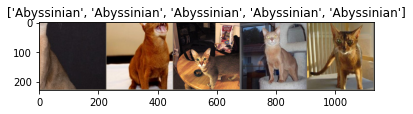

In [39]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

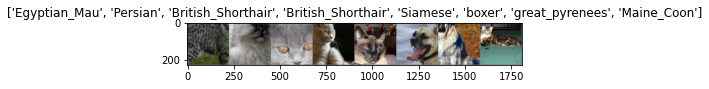

In [40]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## 2. Exercise: modifying VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`.
For next calls, the model will be directly read from there.

In [42]:
class_number = len(dsets['trainval'].classes)
model_vgg =  models.vgg16(pretrained=True)
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier._modules['6'] = nn.Linear(4096, class_number)
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=37, bias=True)
  (7): LogSoftmax(dim=1)
)


In [46]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [ ]:
outputs_try = model_vgg(inputs_try)

In [ ]:
outputs_try

In [ ]:
outputs_try.shape

### Modifying the last layer and setting the gradient false to all layers

In [ ]:
print(model_vgg)

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

![vgg16](https://dataflowr.github.io/notebooks/Module1/img/vgg16.png)

Here, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last ```nn.Linear``` layer trained for 1000 classes to ones with 37 classes. In order to freeze the weights of the other layers during training, we set the field ```required_grad=False```. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 37-class layer will be updated.

PyTorch documentation for [LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)

In [ ]:
for param in model_vgg.parameters():
    param.requires_grad = False
# your code here


In [ ]:
print(model_vgg.classifier)

Once you modified the architecture of the network, do not forget to put in onto the device!

In [ ]:
# your code here

## Training fully connected module

### Creating loss function and optimizer

PyTorch documentation for [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) and the [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [43]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Training the model

In [44]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [47]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['trainval'],epochs=2,optimizer=optimizer_vgg)

Loss: 0.0521 Acc: 0.1253
Loss: 0.0386 Acc: 0.4293
CPU times: user 33.9 s, sys: 1.03 s, total: 34.9 s
Wall time: 35.8 s


In [57]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,37))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    #print(size)
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [58]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['test'])

Loss: 0.4072 Acc: 0.7035


In [ ]:
# Get a batch of training data
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Compute the predictions made by your network for `inputs[:n_images]` and the associated probabilities.

Hint: use `torch.max` and `torch.exp`.

Do not forget to put your inputs on the device!

In [69]:
# your code here
print(len(inputs))
# vals_try, preds_try = # your code here
vals_try, preds_try = torch.max(model_vgg(inputs.to(device)), dim=1)

vals_try = torch.exp(vals_try)
# vals_try, preds_try = model_vgg()

64



**注**： 

vals_try 是logsoftmax的输出，
$$softmax(logits_{i}) = \frac{exp(logits_{i})}{\sum_{0}^{batchsize}{exp(logits_{k})}} $$

$$logSoftmax(logits) = log(\frac{exp(logits_{i})}{\sum_{0}^{batchsize}{exp(logits_{i})}})$$


> 我的理解是这样的：理论上对于单标签多分类问题，直接经过softmax求出概率分布，然后把这个概率分布用crossentropy做一个似然估计误差。但是softmax求出来的概率分布，每一个概率都是(0,1)的，这就会导致有些概率过小，导致下溢。

> 考虑到这个概率分布总归是要经过crossentropy的，而crossentropy的计算是把概率分布外面套一个-log 来似然，那么直接在计算概率分布的时候加上log,把概率从（0，1）变为（-∞，0），这样就防止中间会有下溢出。

> 所以log_softmax说白了就是将本来应该由crossentropy做的套log的工作提到预测概率分布来，跳过了中间的存储步骤，防止中间数值会有下溢出，使得数据更加稳定。

> 正是由于把log这一步从计算误差提到前面，所以用log_softmax之后，下游的计算误差的function就应该变成NLLLoss(它没有套log这一步，直接将输入取反，然后计算和label的乘积求和平均)


In [61]:
preds_try

tensor([[-4.0159, -2.7745, -3.3203,  ..., -3.6554, -3.7503, -3.9511],
        [-4.7645, -4.3254, -2.6765,  ..., -5.5549, -6.0617, -5.2708],
        [-3.8192, -4.0495, -2.8809,  ..., -3.7471, -4.4306, -4.8006],
        ...,
        [-3.4723, -4.0325, -2.8582,  ..., -3.7747, -4.2074, -4.1144],
        [-3.0528, -4.0561, -2.4717,  ..., -3.9848, -4.9534, -4.5539],
        [-5.1239, -4.6468, -4.3286,  ..., -4.0050, -3.3700, -5.0963]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [ ]:
classes[:n_images]

In [ ]:
# torch.exp(vals_try)

## Speeding up the learning by precomputing features

In [70]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [71]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 16 s, sys: 886 ms, total: 16.9 s
Wall time: 17.3 s


In [72]:
conv_feat_train.shape

(3680, 512, 7, 7)

In [73]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 19.4 s, sys: 1.33 s, total: 20.8 s
Wall time: 21 s


### Creating a new data generator

We will not load images anymore, so we need to build our own data loader.

In [74]:
?torch.utils.data.DataLoader

Init signature: torch.utils.data.DataLoader(*args, **kwds)
Docstring:     
Data loader. Combines a dataset and a sampler, and provides an iterable over
the given dataset.

The :class:`~torch.utils.data.DataLoader` supports both map-style and
iterable-style datasets with single- or multi-process loading, customizing
loading order and optional automatic batching (collation) and memory pinning.

See :py:mod:`torch.utils.data` documentation page for more details.

Args:
    dataset (Dataset): dataset from which to load the data.
    batch_size (int, optional): how many samples per batch to load
        (default: ``1``).
    shuffle (bool, optional): set to ``True`` to have the data reshuffled
        at every epoch (default: ``False``).
    sampler (Sampler or Iterable, optional): defines the strategy to draw
        samples from the dataset. Can be any ``Iterable`` with ``__len__``
        implemented. If specified, :attr:`shuffle` must not be specified.
    batch_sampler (Sampler or Iter

In [75]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

Now you can train for more epochs.

In [77]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['trainval'],epochs=80,optimizer=optimizer_vgg)

Loss: 0.0159 Acc: 0.5880
Loss: 0.0142 Acc: 0.6421
Loss: 0.0129 Acc: 0.6856
Loss: 0.0118 Acc: 0.7269
Loss: 0.0109 Acc: 0.7489
Loss: 0.0102 Acc: 0.7633
Loss: 0.0096 Acc: 0.7709
Loss: 0.0090 Acc: 0.7943
Loss: 0.0086 Acc: 0.7883
Loss: 0.0081 Acc: 0.8030
Loss: 0.0078 Acc: 0.8125
Loss: 0.0074 Acc: 0.8253
Loss: 0.0073 Acc: 0.8163
Loss: 0.0069 Acc: 0.8277
Loss: 0.0068 Acc: 0.8283
Loss: 0.0066 Acc: 0.8293
Loss: 0.0064 Acc: 0.8375
Loss: 0.0062 Acc: 0.8378
Loss: 0.0061 Acc: 0.8408
Loss: 0.0059 Acc: 0.8424
Loss: 0.0058 Acc: 0.8484
Loss: 0.0057 Acc: 0.8470
Loss: 0.0055 Acc: 0.8549
Loss: 0.0055 Acc: 0.8489
Loss: 0.0053 Acc: 0.8571
Loss: 0.0053 Acc: 0.8527
Loss: 0.0050 Acc: 0.8636
Loss: 0.0051 Acc: 0.8636
Loss: 0.0050 Acc: 0.8590
Loss: 0.0048 Acc: 0.8682
Loss: 0.0048 Acc: 0.8655
Loss: 0.0047 Acc: 0.8671
Loss: 0.0047 Acc: 0.8682
Loss: 0.0046 Acc: 0.8644
Loss: 0.0046 Acc: 0.8666
Loss: 0.0045 Acc: 0.8685
Loss: 0.0045 Acc: 0.8693
Loss: 0.0043 Acc: 0.8742
Loss: 0.0043 Acc: 0.8785
Loss: 0.0043 Acc: 0.8731


In [78]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

Now you can compute the accuracy on the test set.

In [79]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['test'])

Loss: 0.0035 Acc: 0.8850


## Confusion matrix

For 37 classes, plotting a confusion matrix is useful to see the performance of the algorithm per class.

In [ ]:
#!pip install -U scikit-learn

In [80]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
    fig = plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(37);
    plt.xticks(tick_marks, dset_classes, rotation=90);
    plt.yticks(tick_marks, dset_classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

In [81]:
cm = confusion_matrix(all_classes,predictions)

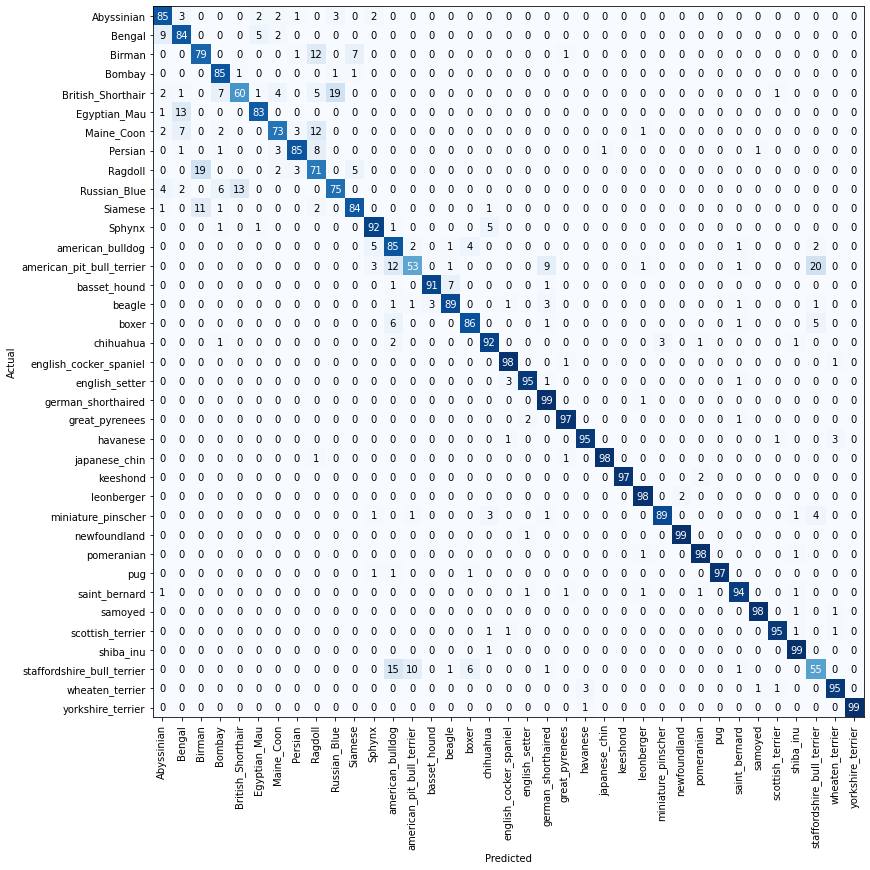

In [82]:
make_fig_cm(cm)

Here, you see that [american pit bull terrier](https://en.wikipedia.org/wiki/American_Pit_Bull_Terrier) are often predicted as [staffordshire bull terrier](https://en.wikipedia.org/wiki/Staffordshire_Bull_Terrier) but overall your algorithm should give pretty good results!

## 3. Exercise: change of neural network model

Great! So far, you reproduced the result of the first lesson. Now, you will need to take another model. I propose to take a `resnet34` from the list availabel [here](https://pytorch.org/docs/stable/torchvision/models.html)

__Note__ the main purpose of this exercise is to lean how to modify a network. We do not really care about performances...

In [84]:
# model_resnet = # your code here
model_resnet =  models.resnet34(pretrained=True)
# for param in model_resnet.parameters():
#     param.requires_grad = False
# model_vgg.classifier._modules['6'] = nn.Linear(4096, class_number)
# model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)
# print(model_vgg.classifier)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/andy/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [85]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

OK, the strucutre is quite different from the one of VGG we saw during the course but we still see that the last layer is a Linear layer taking a vector of size 512 and producing a vector of size 1000 (i.e. the number of classes in Imagenet). Hence you should be able to modify this network for your classification task with 37 classes!

First freeze the weights of your model and replace the last layer by a Linear layer with the appropriate size.

In [91]:
# your code here
#Hint print(model_resnet.fc)
for param in model_resnet.parameters():
    param.requires_grad = False

model_resnet.fc = nn.Linear(512, class_number)
print(model_resnet)
# model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now we need to add the LogSoftmax layer. Follow the instructions [here](https://discuss.pytorch.org/t/how-to-add-an-additional-layer-on-top-of-a-pretrained-model/21303/2) to add this layer

In [92]:
model_resnet_lsm = nn.Sequential(model_resnet, nn.LogSoftmax(dim=1))
print(model_resnet_lsm)

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

Check that everything is working fine!

In [93]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)
model_resnet_lsm = model_resnet_lsm.to(device)
outputs_try = model_resnet_lsm(inputs_try)

In [94]:
outputs_try.shape

torch.Size([5, 37])

Now you can start training.

You will take the same loss as before: [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) but you need to modify the argument of the optimizer [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [95]:
#Hint print(model_resnet_lsm[0].fc)
# criterion = nn.NLLLoss()
lr = 0.001
# optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)
optimizer_resnet = torch.optim.SGD(filter(lambda p: p.requires_grad, model_resnet_lsm.parameters()),lr = lr)

Now you can use the same function as above for the training loop.

In [97]:
%%time
train_model(model_resnet_lsm,loader_train,size=dset_sizes['trainval'],epochs=30,optimizer=optimizer_resnet)

Loss: 0.0595 Acc: 0.0239
Loss: 0.0557 Acc: 0.0522
Loss: 0.0529 Acc: 0.1011
Loss: 0.0505 Acc: 0.1726
Loss: 0.0483 Acc: 0.2397
Loss: 0.0462 Acc: 0.3182
Loss: 0.0442 Acc: 0.3856
Loss: 0.0423 Acc: 0.4511
Loss: 0.0405 Acc: 0.4986
Loss: 0.0388 Acc: 0.5486
Loss: 0.0371 Acc: 0.5853
Loss: 0.0356 Acc: 0.6193
Loss: 0.0341 Acc: 0.6473
Loss: 0.0327 Acc: 0.6783
Loss: 0.0316 Acc: 0.6981
Loss: 0.0303 Acc: 0.7166
Loss: 0.0293 Acc: 0.7291
Loss: 0.0282 Acc: 0.7432
Loss: 0.0272 Acc: 0.7582
Loss: 0.0264 Acc: 0.7639
Loss: 0.0255 Acc: 0.7682
Loss: 0.0247 Acc: 0.7807
Loss: 0.0240 Acc: 0.7902
Loss: 0.0233 Acc: 0.7965
Loss: 0.0225 Acc: 0.8079
Loss: 0.0219 Acc: 0.8092
Loss: 0.0214 Acc: 0.8095
Loss: 0.0207 Acc: 0.8177
Loss: 0.0202 Acc: 0.8231
Loss: 0.0198 Acc: 0.8261
CPU times: user 2min 40s, sys: 15.9 s, total: 2min 56s
Wall time: 3min 5s


In [98]:
%%time
predictions, all_proba, all_classes = test_model(model_resnet_lsm,loader_valid,size=dset_sizes['test'])

Loss: 0.2527 Acc: 0.7991
CPU times: user 7.89 s, sys: 948 ms, total: 8.84 s
Wall time: 9.73 s


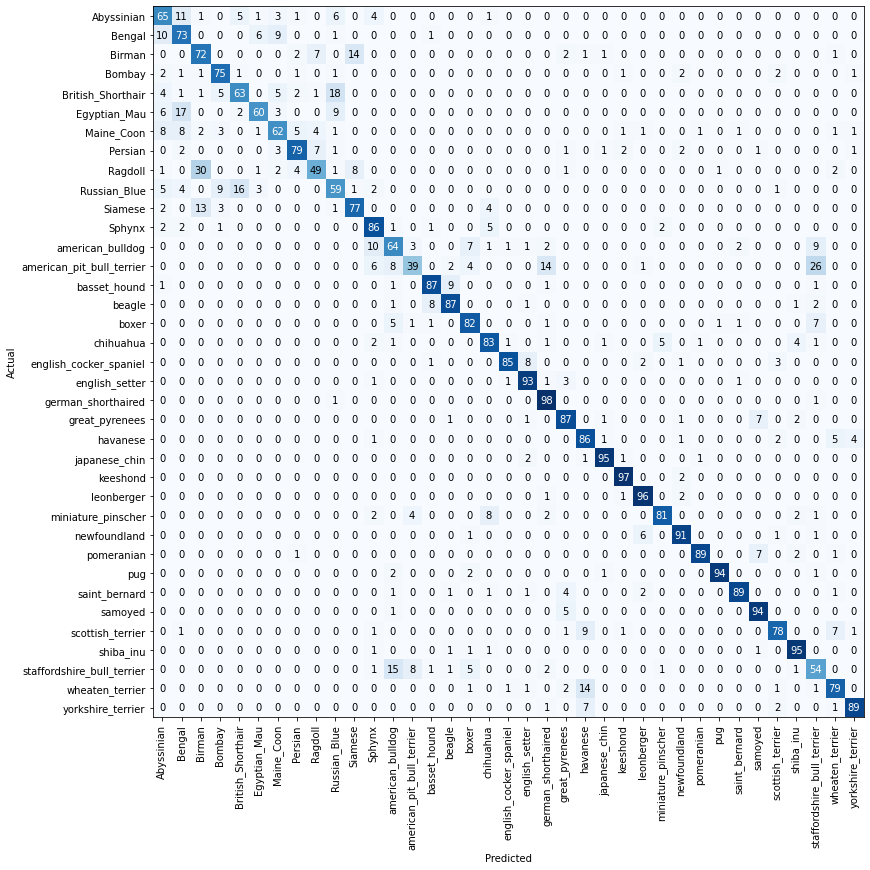

In [99]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

## Well done!

What would you do to speed up the process in the last part?

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)